In [1]:
import sys
import matplotlib as m

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np

import tensorflow as tf
from tensorflow import keras

from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import BSpline
from scipy.interpolate import griddata

from sklearn.model_selection import train_test_split

from tqdm import tqdm

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
SEED_N = 2
np.random.seed(seed=SEED_N)

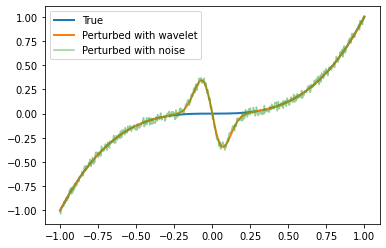

In [3]:
n_points = 500
x_low = -1
x_high = 1
x = np.linspace(-1, 1, n_points, dtype='float32')
y_true = np.power(x, 3)
y_wave = np.power(x, 3) - 8 * x * np.exp(-100 * np.square(x))
y_perturbed = y_wave + np.random.uniform(-0.05, 0.05, n_points)
fig, ax = plt.subplots()
ax.plot(x, y_true, linewidth=2.0)
ax.plot(x, y_wave, linewidth=2.0)
ax.plot(x, y_perturbed, alpha=0.5)
ax.legend(['True', 'Perturbed with wavelet', 'Perturbed with noise'])

In [4]:
tf.constant([0.0]).ndim

1

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y_perturbed, test_size=0.33, random_state=42)

Lets learn the result with a nerual net with 3 deep layers.

In [6]:
# SEED FOR WEIGHTS
tf.random.set_seed(SEED_N)

architecture = [10, 10, 10]
modelnn = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu') for a in architecture] + [tf.keras.layers.Dense(1, activation='linear')])
modelnn.build(input_shape=(None,1))
modelnn.compile(optimizer="Adam", loss="mse", metrics=["mae"])
modelnn.summary()

modelnnobj = [modelnn, modelnn.get_weights()]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [7]:
# This might be silencing something useful, but atm there is a bug in Tensorflow

# tf.autograph.set_verbosity(0)


def continuous_training_loop(modelobj, x_trn, y_trn, epochs, bs, training_splits=3):
    modeltotrn, weights = modelobj
    modeltotrn.set_weights(weights)
    fig, ax = plt.subplots(nrows = training_splits, figsize=(15,6))
    train_epochs = int(epochs / training_splits)
    for i in range(training_splits):
        modeltotrn.fit(x_trn, y_trn, epochs=train_epochs, verbose=0, batch_size=bs, shuffle=True)
        ax[i].plot(x_trn, y_trn, 'x')
        y_pred = modeltotrn(x_trn[:, None]).numpy().flatten()
        ax[i].plot(x_trn, y_pred, 'x')
        ax[i].plot(x, y_wave)
        print(f"Training loss at split {i}: {tf.reduce_sum(tf.keras.losses.MSE(y_trn, y_pred))}")

Training loss at split 0: 0.005361943505704403
Training loss at split 1: 0.0028502659406512976
Training loss at split 2: 0.0021243426017463207


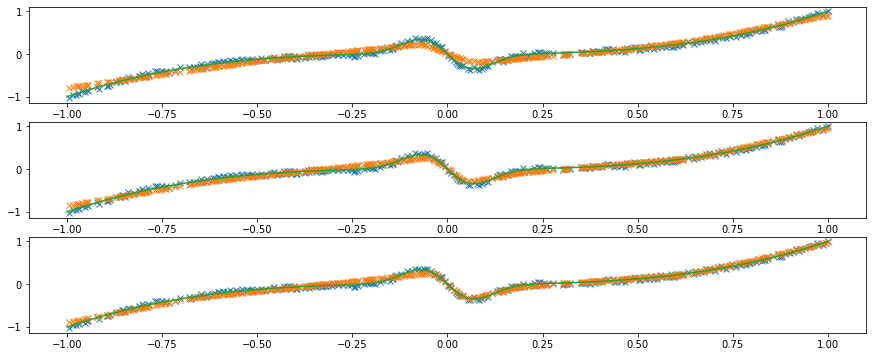

In [8]:
epochs = 150
bs = 30
splits= 3

continuous_training_loop(modelnnobj, X_train, y_train, epochs=epochs, bs=bs, training_splits=splits)

Here I explore what does batch size do with the learning.

Training loss at split 0: 0.009939811192452908
Training loss at split 1: 0.006307217758148909
Training loss at split 2: 0.0043432218953967094


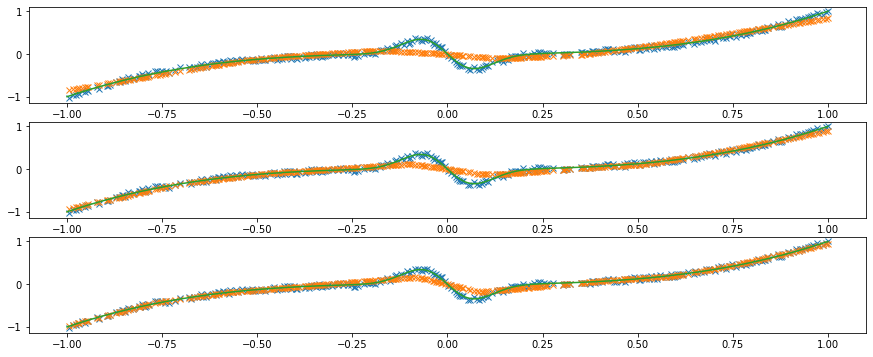

In [9]:
epochs = 150
bs = 60
splits= 3

continuous_training_loop(modelnnobj, X_train, y_train, epochs=epochs, bs=bs, training_splits=splits)

Training loss at split 0: 0.023892268538475037
Training loss at split 1: 0.012820198200643063
Training loss at split 2: 0.009953174740076065


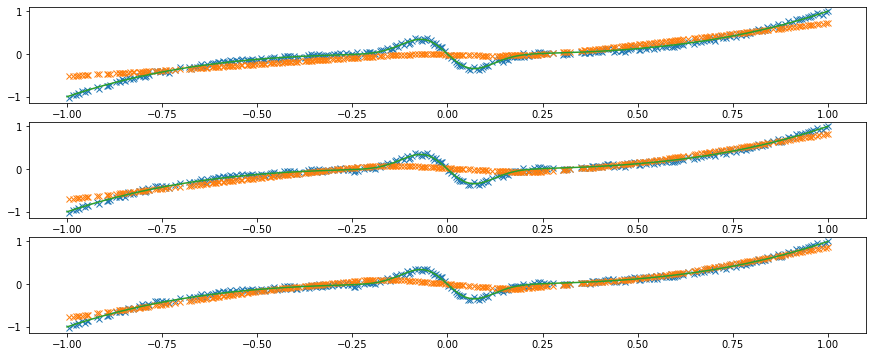

In [10]:
epochs = 150
bs = 200
splits= 3

continuous_training_loop(modelnnobj, X_train, y_train, epochs=epochs, bs=bs, training_splits=splits)

Let's try a regularizer in L1 and L2 sense, that is 

$$ J(w^{(1)}, b^{(1)}, \dots, w^{(3)}, b^{(3)}) = \frac{1}{m}\sum_{i=1}^m L(\hat{y}^i, y^i)^2 + \frac{\lambda}{2m} \sum_{l=1}^L||w^l||^2_F$$,

furthermore, we can apply regularization both on weights and biases, as well as in L1 or L2 sense

## L2 regularizer

In [11]:
# SEED FOR WEIGHTS
tf.random.set_seed(SEED_N)

architecture = [10, 10, 10]
reg_param = 0.001
modelnnl2 = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_param),bias_regularizer=tf.keras.regularizers.l2(reg_param)) for a in architecture] + 
                                [tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(reg_param),bias_regularizer=tf.keras.regularizers.l2(reg_param))])
modelnnl2.build(input_shape=(None,1))
modelnnl2.compile(optimizer="Adam", loss="mse", metrics=["mae"])
modelnnl2.summary()

modelnnl2.set_weights(modelnnobj[1])

modelnnobjl2 = [modelnnl2, modelnnl2.get_weights()]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


Training loss at split 0: 0.010216837748885155
Training loss at split 1: 0.006664005108177662
Training loss at split 2: 0.005591606255620718


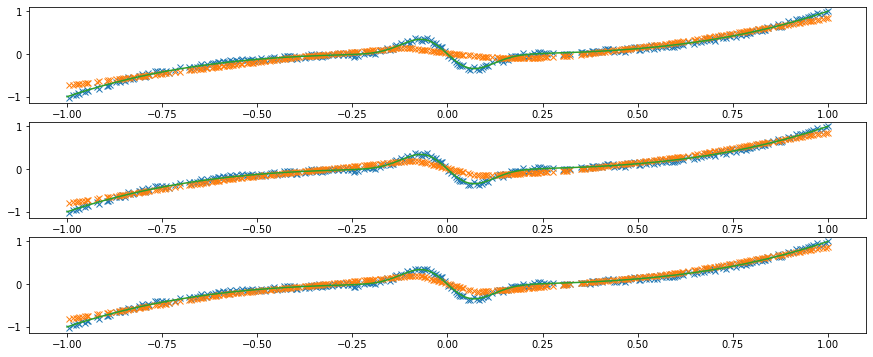

In [12]:
epochs = 150
bs = 30
splits= 3

continuous_training_loop(modelnnobjl2, X_train, y_train, epochs=epochs, bs=bs, training_splits=splits)

## L1 regularizer

In [13]:
# SEED FOR WEIGHTS
tf.random.set_seed(SEED_N)

architecture = [10, 10, 10]
reg_param = 0.001
modelnnl1 = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(reg_param)) for a in architecture] + 
                                [tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l1(reg_param))])
modelnnl1.build(input_shape=(None,1))
modelnnl1.compile(optimizer="Adam", loss="mse", metrics=["mae"])
modelnnl1.summary()

modelnnl1.set_weights(modelnnobj[1])

modelnnobjl1 = [modelnnl1, modelnnl1.get_weights()]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


Training loss at split 0: 0.012307382188737392
Training loss at split 1: 0.010696498677134514
Training loss at split 2: 0.009392471984028816


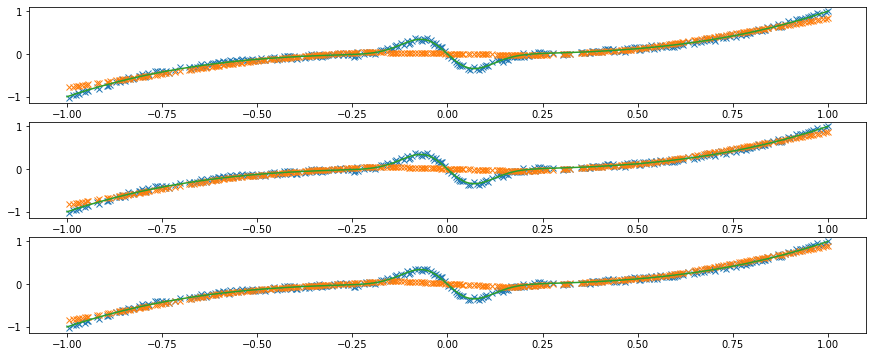

In [14]:
epochs = 150
bs = 30
splits= 3

continuous_training_loop(modelnnobjl2, X_train, y_train, epochs=epochs, bs=bs, training_splits=splits)

## L1 and L2

In [15]:
# SEED FOR WEIGHTS
tf.random.set_seed(SEED_N)

architecture = [10, 10, 10]
reg_param = 0.001
modelnnl1l2 = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=reg_param, l2= reg_param)) for a in architecture] + 
                                [tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=reg_param, l2= reg_param))])
modelnnl1l2.build(input_shape=(None,1))
modelnnl1l2.compile(optimizer="Adam", loss="mse", metrics=["mae"])
modelnnl1l2.summary()

modelnnl1l2.set_weights(modelnnobj[1])

modelnnobjl1l2 = [modelnnl1l2, modelnnl1.get_weights()]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


Training loss at split 0: 0.010298031382262707
Training loss at split 1: 0.007520507555454969
Training loss at split 2: 0.006643066182732582


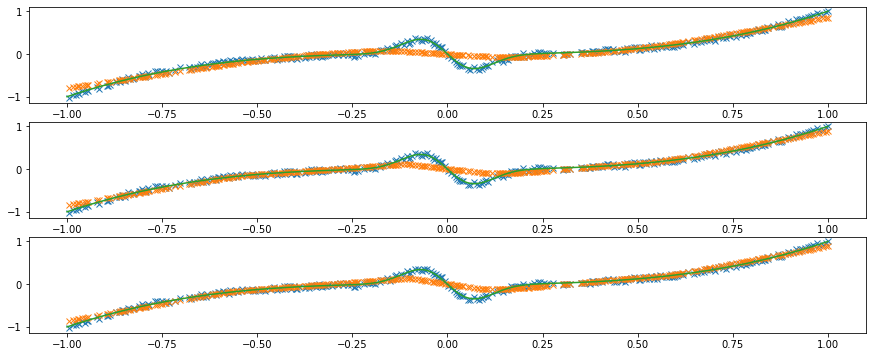

In [16]:
epochs = 150
bs = 30
splits= 3

continuous_training_loop(modelnnobjl2, X_train, y_train, epochs=epochs, bs=bs, training_splits=splits)

## Dropout regularizer

In [17]:
from itertools import chain

architecture = [10, 10, 10]
drop_param = 0.001

layers = [tf.keras.layers.Dense(a, activation='relu') for a in architecture]
drop_outs = [tf.keras.layers.Dropout(.2, input_shape=(a,)) for a in architecture]
combined = [None]*(len(layers)+len(drop_outs))
combined[::2] = layers
combined[1::2] = drop_outs

modelnndrop = tf.keras.Sequential(combined + 
                                [tf.keras.layers.Dense(1, activation='linear')])
modelnndrop.build(input_shape=(None,1))
modelnndrop.compile(optimizer="Adam", loss="mse", metrics=["mae"])
modelnndrop.summary()

modelnndrop.set_weights(modelnnobj[1])

modelnnobjdrop = [modelnndrop, modelnndrop.get_weights()]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                20        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

Training loss at split 0: 0.00943092629313469
Training loss at split 1: 0.007547841873019934
Training loss at split 2: 0.006346799433231354


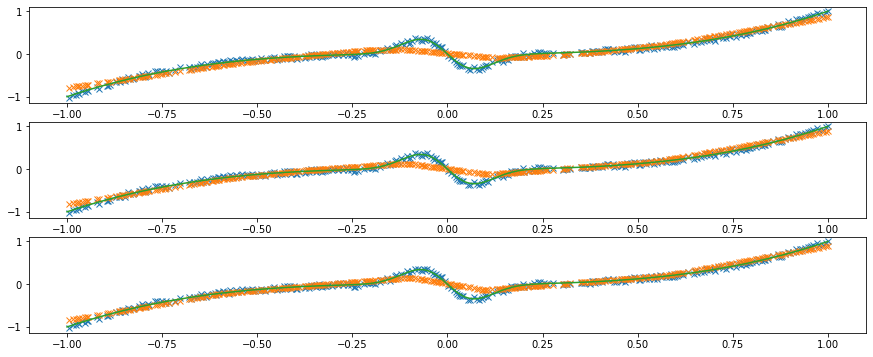

In [18]:
epochs = 150
bs = 30
splits= 3

continuous_training_loop(modelnnobjl2, X_train, y_train, epochs=epochs, bs=bs, training_splits=splits)

## Monotonic regularization

Therefore, to a certain extent, the regularization indeed helps.

Custom training loop and penalization 

In [ ]:
def train_step(trainable_model, dset, epoch=0):  
    batch_loss = np.zeros(len(dset))
    batch_penal = np.zeros(len(dset))
    for i, (x_batch, y_batch) in enumerate(dset):
        input_var = tf.Variable(x_batch, name='temp_input_var')
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(input_var)
            predictions = trainable_model(input_var, training=True)
            penal = 1 * tf.reduce_sum(tf.math.maximum(-tape.gradient(predictions, input_var), 0.0))
            # print(f'Gradient val: {tape.gradient(predictions, input_var)}')
            loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, predictions)) + penal
            # batch_penal[i] = tape.gradient(loss_value, input_var)
            batch_penal[i] = penal.numpy()
            batch_loss[i] = loss_value.numpy()
        gradients = tape.gradient(loss_value, trainable_model.trainable_variables)
        del tape
        trainable_model.optimizer.apply_gradients(zip(gradients, trainable_model.trainable_variables))
    return np.mean(batch_loss), np.mean(batch_penal)


def fit_model(trainable_model, X, y, epochs, batch=32, verbose=False, shuffle=False):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    y = y[:, None]
    X = X[:, None]
    if shuffle:
        #x, y = unison_shuffled_copies(x, y)
        dset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(len(y)).batch(batch)
    else:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch)
    for i, epoch in enumerate(range(0, epochs)):
        losses[i], penalizations[i] = train_step(trainable_model, dset=dset, epoch=i)
        if verbose:
            print(f'Epoch:{i}/{epochs} Loss: {losses[i]}')
    return losses, penalizations

def unison_shuffled_copies(a, b):
    # shuffles the two arrays such that they preserve their feature order
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p, :], b[p]


class Penal:
    def __init__(self):
        pass
    
    def calc_penal(self):
        pass

In [ ]:
architecture = [20, 20, 20]
modelnncust = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu') for a in architecture] + [tf.keras.layers.Dense(1, activation='linear')])
modelnncust.build(input_shape=(None,1))
modelnncust.compile(optimizer="Adam", loss="mse", metrics=["mae"])

epochs = 300
bs = 30
splits= 3

losses, penals = fit_model(modelnncust, X_train, y_train, epochs=epochs, batch=bs, verbose=False, shuffle=True)

In [ ]:
plt.plot(losses)

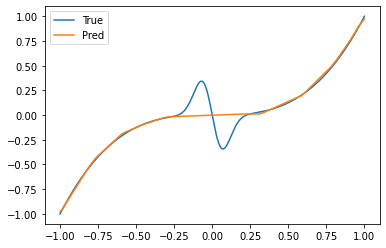

In [22]:
fix, ax = plt.subplots()

ax.plot(x, y_wave)
y_pred = modelnncust(x[:, None]).numpy().flatten()
ax.plot(x, y_pred)
ax.legend(['True', 'Pred'])
# ax[i].plot(x, y_wave)

In [23]:
model_in = tf.keras.Input(shape=(1,))
model_d1 = tf.keras.layers.Dense(64, activation='relu')(model_in)
model_d2 = tf.keras.layers.Dense(64, activation='relu')(model_d1)
model_d3 = tf.keras.layers.Dense(1)(model_d2)
model = tf.keras.Model(inputs=[model_in], outputs=[model_d3])
model.compile(loss='mse')
model.summary()

model.fit(x, y_wave, epochs=200, verbose=0)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [24]:
v = tf.Variable(x[:, None], name='v_var')
with tf.GradientTape() as tape:
    tape.watch(v)
    model_vals = model(v)
print(len(tape.watched_variables())) 
model_grad = tape.gradient(model_vals, v)

7


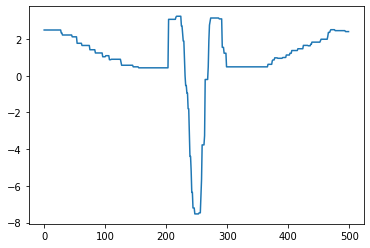

In [25]:
plt.plot(model_grad)

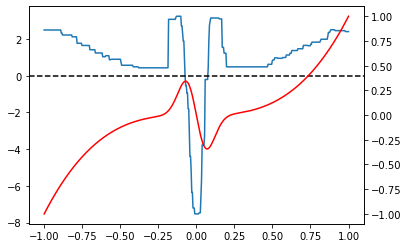

In [26]:
fig, ax = plt.subplots()
ax.plot(x, model_grad.numpy().flatten())
ax1= ax.twinx()
ax1.plot(x, y_wave, color='red')
ax.axhline(0, color='black', linestyle='--')

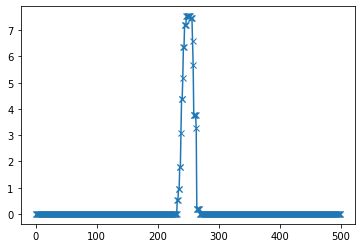

In [27]:
plt.plot(tf.math.maximum(-model_grad, 0).numpy().flatten(), marker='x')

## Learning AAV for two actions using monotonic penalization
Lets try it in multiple dimensions

In [28]:
p = Parameters()
aav= AAV(p)
w_points = 200
l_points = 100
ws = np.linspace(0, 200, w_points)
ls = np.linspace(0, 5, l_points)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
zt = np.zeros_like(ww)
coord = []
targets = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly, wx)
        zt[j, i] = -aav.u(ly + 3, wx) - 15
        #features.append([ly, wx, z[j, i], zt[j, i]])
        coord.append([ly, wx])
        targets.append([z[j, i], zt[j, i]])
coord = np.array(coord, dtype='float32')
targets = np.array(targets, dtype='float32')

[INFO] [2021-04-19 14:39:16,037] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'q(2)')

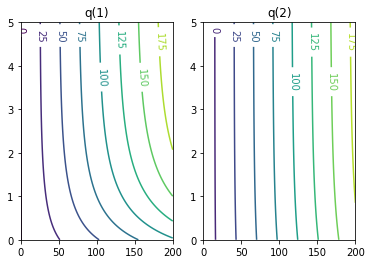

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=1)
CS = ax[0].contour(ww, ll, z)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('q(1)')
CS = ax[1].contour(ww, ll, zt)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('q(2)')

In [30]:
X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(coord, targets, train_size=0.2)

In [31]:
model_in = tf.keras.Input(shape=(2,))
model_d1 = tf.keras.layers.Dense(64, activation='relu')(model_in)
model_d2 = tf.keras.layers.Dense(64, activation='relu')(model_d1)
model_d3 = tf.keras.layers.Dense(64, activation='relu')(model_d2)
model_d4 = tf.keras.layers.Dense(2)(model_d3)
model2d = tf.keras.Model(inputs=[model_in], outputs=[model_d4])
model2d.compile(loss='mse')
model2d.summary()

model2d_obj = [model2d, model2d.get_weights()]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 130       
Total params: 8,642
Trainable params: 8,642
Non-trainable params: 0
_________________________________________________________________


In [32]:
model2d.fit(X2d_train, y2d_train, epochs=300, batch_size=32, verbose=0)

In [33]:
def train_step_2d(trainable_model, dset, epoch=0):  
    batch_loss = np.zeros(len(dset))
    batch_penal = np.zeros(len(dset))
    batch_msme = np.zeros(len(dset))
    for i, (x_batch, y_batch) in enumerate(dset):
        input_var = tf.Variable(x_batch, name='temp_input_var')
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(input_var)
            predictions = trainable_model(input_var, training=True)
            penal = 10 * tf.reduce_sum(tf.math.maximum(-tape.jacobian(predictions, input_var), 0.0))
            # penal = 0.0
            # print(f'Gradient val: {tape.gradient(predictions, input_var)}')
            loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, predictions)) + penal
        gradients = tape.gradient(loss_value, trainable_model.trainable_variables)
        trainable_model.optimizer.apply_gradients(zip(gradients, trainable_model.trainable_variables))
        batch_penal[i] = penal.numpy()
        batch_loss[i] = loss_value.numpy()
        batch_msme = MSME2d(x_batch, trainable_model)
    return np.mean(batch_loss), np.mean(batch_penal), np.mean(batch_msme)


def fit_model_2d(trainable_model, X, y, epochs, batch_size=32, verbose=False, shuffle=False):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    msmes = np.zeros(epochs)
    if shuffle:
        #x, y = unison_shuffled_copies(x, y)
        dset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(len(y)).batch(batch_size)
    else:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch_size)
    for epoch in range(0, epochs):
        losses[epoch], penalizations[epoch], msmes[epoch] = train_step_2d(trainable_model, dset=dset, epoch=epoch)
        if verbose:
            print(f'Epoch:{epoch}/{epochs} Loss: {losses[epoch]}')
    return losses, penalizations, msmes


def unison_shuffled_copies(a, b):
    # shuffles the two arrays such that they preserve their feature order
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p, :], b[p]
   
def plot_3d(x, y, z):
    z1 = z[:, 0]
    z2 = z[:, 1]
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z1 = griddata((x, y), z1, (grid_x, grid_y), method='cubic')
    grid_z2 = griddata((x, y), z2, (grid_x, grid_y), method='cubic')
    fig, ax = plt.subplots(ncols=2, nrows=1)
    CS = ax[0].contour(grid_x, grid_y, grid_z1)
    ax[0].clabel(CS, inline=1, fontsize=10)
    ax[0].set_title('spline q(1)')
    CS = ax[1].contour(grid_x, grid_y, grid_z2)
    ax[1].clabel(CS, inline=1, fontsize=10)
    ax[1].set_title('spline q(1)')

    
def MSME2d(input_x, trained_model):
    # Mean Square Monotonicity Error (MSME)
    var_test = tf.Variable(input_x)
    with tf.GradientTape() as tape:
        tape.watch(var_test)
        preds = trained_model(var_test)
    jacob = tape.batch_jacobian(preds, var_test)
    return tf.reduce_sum(0.5 * tf.math.maximum(-jacob, 0.))


def continuous_training_loop_2d(modelobj, x_trn, y_trn, epochs, bs, training_splits=3):
    modeltotrn, weights = modelobj
    modeltotrn.set_weights(weights)
    fig, ax = plt.subplots(figsize=(15,6))
    train_epochs = int(epochs / training_splits)
    x_labels = np.arange(train_epochs, epochs + train_epochs, train_epochs)
    msme = []
    mse = []
    for i in range(training_splits):
        modeltotrn.fit(x_trn, y_trn, epochs=train_epochs, verbose=0, batch_size=bs, shuffle=True)
        y_pred = modeltotrn(x_trn).numpy()
        mse.append(tf.reduce_mean(tf.keras.losses.mean_squared_error(y_trn, y_pred)))
        msme.append(MSME2d(x_trn, modeltotrn))
    ax.plot(x_labels, mse, marker='x')
    ax1 = ax.twinx()
    ax1.plot(x_labels, msme, color='red', marker='x')
    ax.set_xlabel('Train steps')
    ax.legend(['MSE'], loc=2)
    ax1.legend(['MSME'], loc=1)
    ax.set_ylabel('MSE')
    ax1.set_ylabel('MSME')
    
    
def continuous_training_decorator(train_splits):
    # Decorates training loop
    def decorator(func):
        def wrapper(*args, **kwargs):
            fig, ax = plt.subplots(figsize=(15,6))
            mse = []
            msme = []
            penalizations = []
            for i in tqdm(range(train_splits)):
                losses, penalizations, msmes = func(*args, **kwargs)
                mse.append(losses[-1])
                # msme.append(penalizations[-1])
                msme.append(msmes[-1])

            ax.plot(mse, marker='x')
            ax1 = ax.twinx()
            ax1.plot(msme, color='green', marker='x')
            ax.set_xlabel('Train steps')
            ax.legend(['MSE'], loc=2)
            ax1.legend(['MSME'], loc=1)
            ax.set_ylabel('MSE')
            ax1.set_ylabel('MSME')
            return fig, ax
        return wrapper
    return decorator   

[WARNING] [2021-04-19 14:39:51,916] [tensorflow] - 5 out of the last 5 calls to <function pfor.<locals>.f at 0x000001F583B6DB80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[WARNING] [2021-04-19 14:39:55,023] [tensorflow] - 6 out of the last 6 calls to <function pfor.<locals>.f at 0x000001F583B6DB80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repe

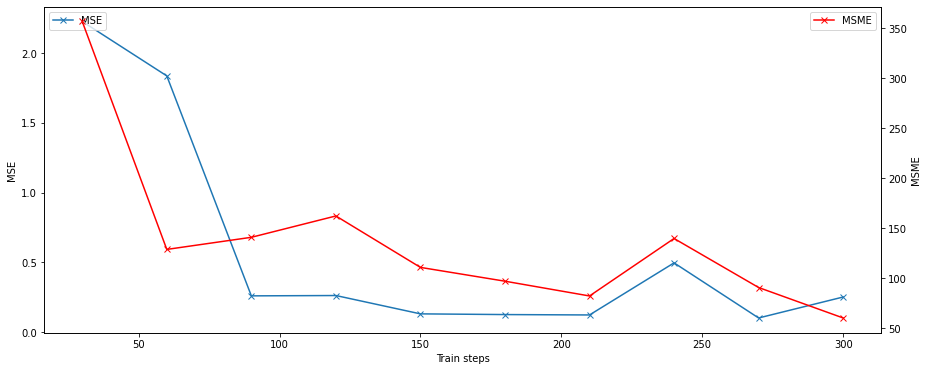

In [34]:
continuous_training_loop_2d(model2d_obj, X2d_train, y2d_train, epochs=300, bs=30, training_splits=10)

MSE: 0.26537585258483887
MSME: 295.16827392578125


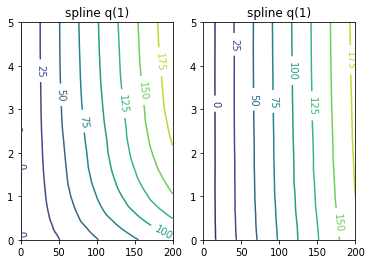

In [35]:
preds = model2d(X2d_test)
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds))}')
print(f'MSME: { MSME2d(X2d_test, model2d)}')

In [36]:
model_inp = tf.keras.Input(shape=(2,))
model_d1p = tf.keras.layers.Dense(64, activation='relu')(model_inp)
model_d2p = tf.keras.layers.Dense(64, activation='relu')(model_d1p)
model_d3p = tf.keras.layers.Dense(64, activation='relu')(model_d2p)
model_d4p = tf.keras.layers.Dense(2)(model_d3p)
model2dp = tf.keras.Model(inputs=[model_inp], outputs=[model_d4p])
model2dp.compile(loss='mse')
model2dp.summary()

model2dp.set_weights(model2d.get_weights())
model2dp_obj = [model2dp, model2dp.get_weights()]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 130       
Total params: 8,642
Trainable params: 8,642
Non-trainable params: 0
_________________________________________________________________


In [37]:
%%timeit
fit_model_2d(model2dp, X2d_train, y2d_train, epochs=1, shuffle=True, batch_size=100)

[WARNING] [2021-04-19 14:40:09,168] [tensorflow] - Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
28.1 s ± 2.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [57:32<00:00, 345.22s/it]


(<Figure size 1080x432 with 2 Axes>,
 <AxesSubplot:xlabel='Train steps', ylabel='MSE'>)

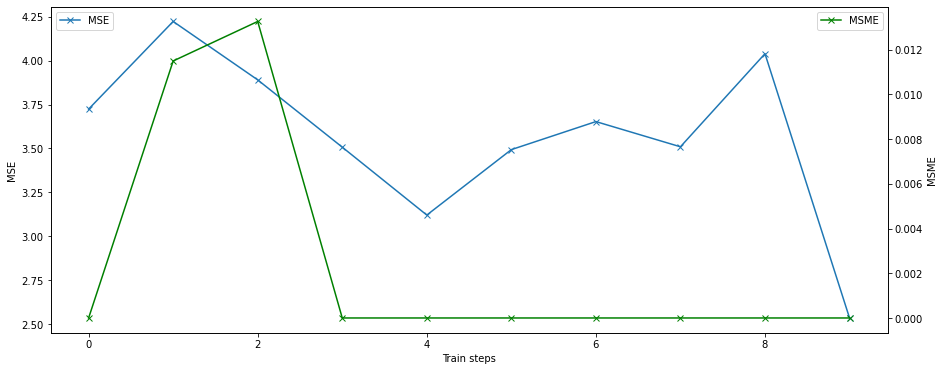

In [38]:
continuous_training_decorator(train_splits=10)(fit_model_2d)(model2dp, X2d_train, y2d_train, epochs=20, shuffle=True, batch_size=200)

MSE: 0.26537585258483887
MSME: 295.16827392578125
Non penalized


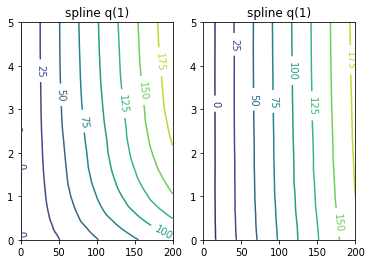

In [39]:
preds = model2d(X2d_test)
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds))}')
print(f'MSME: { MSME2d(X2d_test, model2d)}')
print('Non penalized')

MSE: 0.9863072633743286
MSME: 0.46013665199279785
Penalized


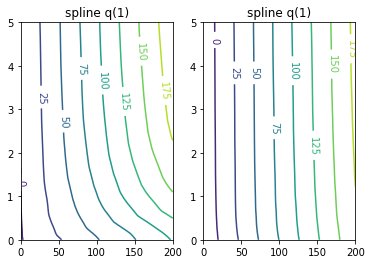

In [40]:
preds = model2dp(X2d_test)
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds))}')
print(f'MSME: { MSME2d(X2d_test, model2dp)}')
print('Penalized')

In [41]:
continuous_training_loop_2d_custom(model2dp_obj, fit_model_2d, X2d_train, y2d_train, epochs=300, bs=32, training_splits=10)

NameError: name 'continuous_training_loop_2d_custom' is not defined

In [ ]:
ls, penals = fit_model_2d(model2dp, X2d_train, y2d_train, epochs=300, shuffle=True)

In [ ]:
preds = modelp.predict_on_batch(X2d_test)
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds))}')
print(f'MSME: { MSME2d(X2d_test, modelp)}')

In [ ]:
plt.plot(penals)

Jacobian penalty:

In [ ]:
architecture = []
modeltest = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu') for a in architecture] + [tf.keras.layers.Dense(2, activation='linear')])
modeltest.build(input_shape=(None, 2))
modeltest.compile(optimizer="Adam", loss="mse", metrics=["mae"])
modeltest.summary()

In [ ]:
modeltest.trainable_variables

In [ ]:
modeltest(x_variable)

In [ ]:
x_variable = tf.constant([[1.0, 2.0]])


with tf.GradientTape(persistent=True) as tape:
    tape.watch(x_variable)
    pred_variable = modeltest(x_variable)

dydw = tape.gradient(pred_variable, modeltest.trainable_variables)
dydx = tape.gradient(pred_variable, x_variable)
Jw = tape.jacobian(pred_variable, modeltest.trainable_variables)
Jx = tape.jacobian(pred_variable, x_variable)

In [ ]:
dydw

In [ ]:
dydx

In [ ]:
Jw

In [ ]:
Jx

In [ ]:
tf.reduce_sum(Jx, axis=1)

In [ ]:
x = tf.Variable(3.0)
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')

In [ ]:
y = x @ w + b

In [ ]:
x